# Сравнение времени работы алгоритмов поиска паросочетаний и поиска маскимальных независимых множеств

В этой работе мы проведем тестирование работы алгоритмов поиска паросочетаний и поиска независимых множеств, встроенных в библиотеку __networkx__, на примере двудольных графов с последовательно изменяющейся плотностью

## Импорт библиотек

In [5]:
# imports
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
import time


# Пример работы алгоритмов

Для начала ознакомимся с тем, как работают алгоритмы maximum_matching и maximal_independent_set на графическом примере:

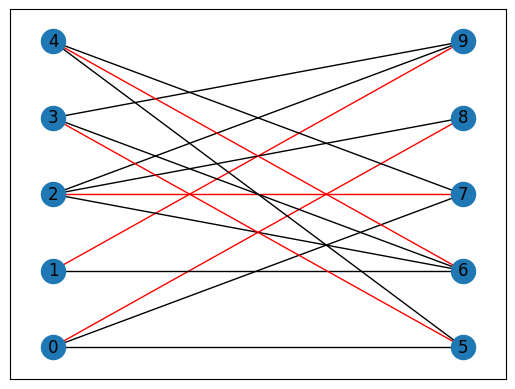

In [ ]:
n = 5  # Число вершин одной доли
p = 0.6  # Плотность графа
B = bipartite.gnmk_random_graph(n, n, n * n * p)  # Создаем граф
matchings = nx.bipartite.maximum_matching(B)  # Вызываем алгоритм

# Красим ребра, помеченные алгоритмом, в красный цвет
edge_color_list = ["black"]*len(B.edges)
for i, edge in enumerate(B.edges()):
    if edge[0] in matchings.keys():
        if matchings[edge[0]] == edge[1]:
            edge_color_list[i] = 'red'

# Отображаем граф
nx.draw_networkx(
    B,
    pos=nx.bipartite_layout(B, np.arange(0, n, 1)),
    edge_color=edge_color_list
)


[9, 7, 5, 6, 8] 5


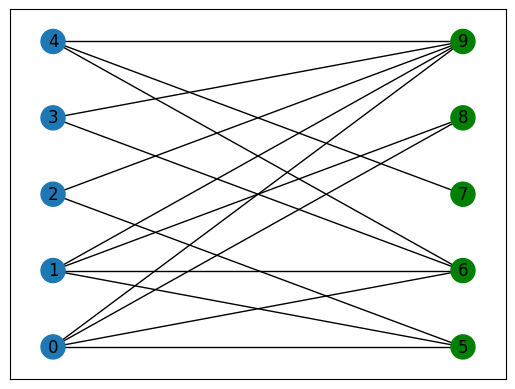

In [ ]:
n = 5
p = 0.6
B = bipartite.gnmk_random_graph(n, n, n * n * p)
ind_set = nx.maximal_independent_set(B)

print(ind_set, len(ind_set))

# Красим вершины независимого множества в зеленый цвет
color_map = []
for node in B:
    if node in ind_set:
        color_map.append('green')
    else:
        color_map.append("#1f78b4")

nx.draw_networkx(
    B,
    node_color=color_map,
    pos=nx.bipartite_layout(B, np.arange(0, n, 1))
)


## Анализ алгоритма поиска паросочетаний

Эта функция принимает на вход следующие параметры:
- starting_left: начальное число вершин левой доли
- starting_right начальное число вершин правой доли
- max_iter: максимальное число попыток создания графа
- limit: лимит вершин, до которого постепенно уменьшается плотность
- time_array: массив засеченного времени для каждого теста
- vertices_array: массив количеств вершин для каждого теста

Функция работает так: она итеративно засекает время работы алгоритма __maximum_matching__, с каждой итерацией создавая новый граф плотностью на 10% меньше. Цикл *for* длины *max_iter* нужен для того, если при создании графа возникнет ошибка, так как при низких плотностях часто может получиться несвязный граф, что не подходит для этого алгоритма. Если создается связный граф, цикл прекращается.

In [17]:
def test_max_matching(starting_left, starting_right, max_iter, limit, time_array, vertices_array):
    full_num_of_v = starting_left * starting_right  # Начальное число ребер
    current_num_of_v = full_num_of_v  # Текущее число ребер
    flag_continue = True  # Флаг для завершения работы цикла while

    # Число, на которое будем уменьшать число ребер с каждой итерацией
    tenth_part = int(current_num_of_v * 0.1)

    # Пока можно продолжать, либо пока не достигли лимита вершин
    while (flag_continue and current_num_of_v > limit):
        for i in range(max_iter):  # Пытаемся создать граф максимально max_iter раз
            if (i == max_iter - 1):  # На низких плотностях, когда дошли до последней попытки, делаем флаг false
                flag_continue = False

            B = bipartite.gnmk_random_graph(
                starting_left, starting_right, current_num_of_v)  # Создаем граф
            try:
                nx.bipartite.maximum_matching(B)
                start = time.perf_counter()  # Засекаем время
                nx.bipartite.maximum_matching(B)  # и пытаемся вызвать алгоритм
                end = time.perf_counter()

                # Добавляем засеченное время в массив
                time_array.append(end - start)
                # Добавляем число вершин в массив
                vertices_array.append(current_num_of_v)

                current_num_of_v -= tenth_part  # Уменьшаем число ребер для следующей итерации
                break
            except Exception:
                print("Disconnected graph, n try =")


Проводим тесты:

In [18]:
# Массивы данных для графиков
matchings_data_time = []
matchings_data_vertices = []
matchings_data_n = []

# Начальные параметры
starting_n = 1000
max_iter = 100
limit = starting_n * starting_n / 2
k = 4  # Коэффициент, на который уменьшаем число вершин долей для следующего теста
time_array = []
vertices_array = []

# Всего проведем 3 теста
while starting_n >= 50:
    test_max_matching(starting_n, starting_n, max_iter, limit,
                      time_array, vertices_array)

    matchings_data_time.append(list(time_array))
    matchings_data_vertices.append(list(vertices_array))
    matchings_data_n.append(starting_n)

    time_array = []
    vertices_array = []

    # Для следующего теста поделим число вершин на k
    starting_n = int(starting_n / k)
    limit = starting_n * starting_n / 2


Рисуем графики:

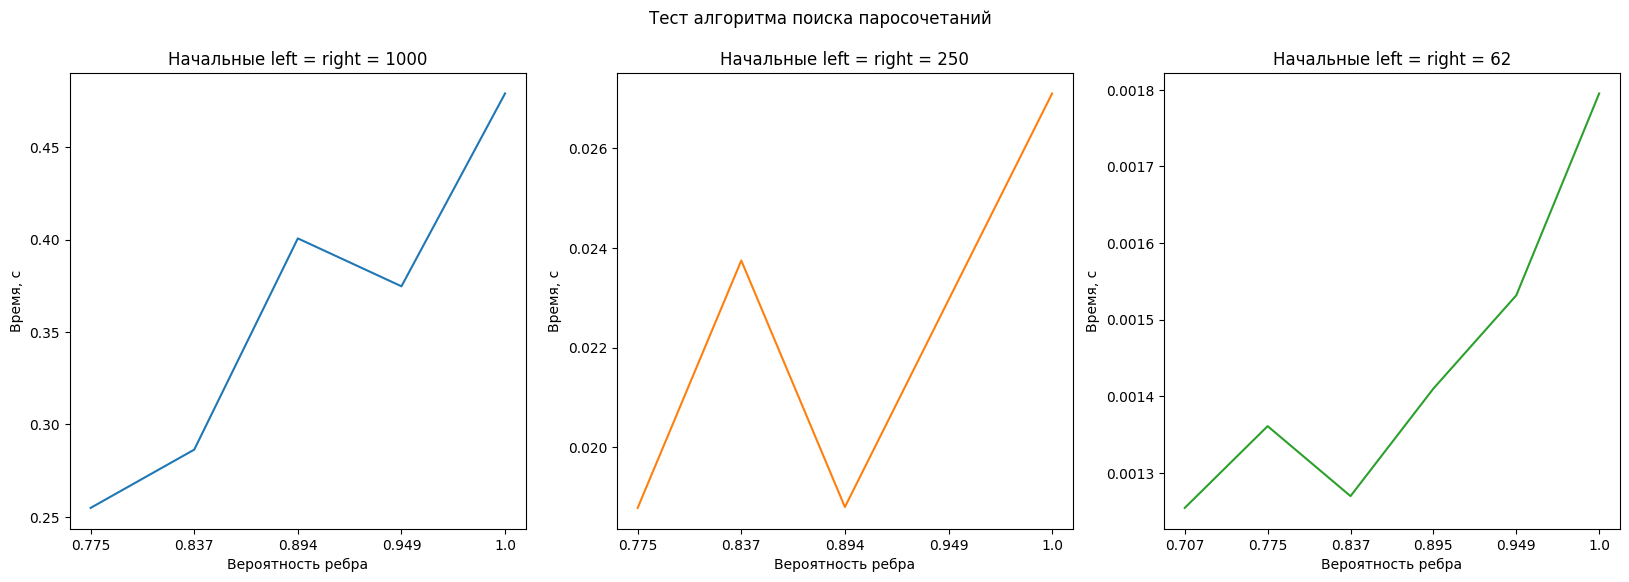

In [94]:
axes_n = 3
counter = 0
fig, axes = plt.subplots(1, axes_n, figsize=(
    20, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

fig.suptitle('Тест алгоритма поиска паросочетаний')

colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(axes_n):
    start = matchings_data_n[i]
    axes[i].set_title("Начальные left = right = {}".format(start))
    axes[i].set(xlabel='Вероятность ребра', ylabel='Время, с')
    edge_probability = [round(x / start, 3)
                        for x in np.sqrt(matchings_data_vertices[i])]
    ticks = np.arange(len(matchings_data_vertices[i]), 0, -1)

    axes[i].set_box_aspect(1)
    axes[i].plot(ticks,
                 matchings_data_time[i], colors[i])
    axes[i].set_xticks(ticks, edge_probability)
plt.show()


## Анализ алгоритма поиска максимального независимого множества

Функция принимает те же параметры

In [77]:
def test_maximal_ind_set(starting_left, starting_right, max_iter, limit, time_array, vertices_array, power_array):
    full_num_of_v = starting_left * starting_right
    current_num_of_v = full_num_of_v
    flag_continue = True

    tenth_part = int(current_num_of_v * 0.1)

    while (flag_continue and current_num_of_v > limit):
        for i in range(max_iter):
            if (i == max_iter - 1):
                flag_continue = False

            B = bipartite.gnmk_random_graph(
                starting_left, starting_right, current_num_of_v)

            try:
                start = time.perf_counter()
                ind_set = nx.maximal_independent_set(B)
                end = time.perf_counter()

                time_array.append(end - start)
                vertices_array.append(current_num_of_v)
                power_array.append(len(ind_set))
                current_num_of_v -= tenth_part
                break
            except Exception:
                print("Disconnected graph, n try =")


In [78]:
sets_data_time = []
sets_data_vertices = []
sets_data_n = []
sets_data_power = []

starting_n = 1000
max_iter = 100
limit = starting_n * starting_n / 2
k = 4
time_array = []
vertices_array = []
power_array = []

while starting_n >= 50:
    test_maximal_ind_set(starting_n, starting_n, max_iter, limit,
                         time_array, vertices_array, power_array)

    sets_data_time.append(list(time_array))
    sets_data_vertices.append(list(vertices_array))
    sets_data_n.append(starting_n)
    sets_data_power.append(list(power_array))

    time_array = []
    vertices_array = []
    power_array = []

    starting_n = int(starting_n / k)
    limit = starting_n * starting_n / 2


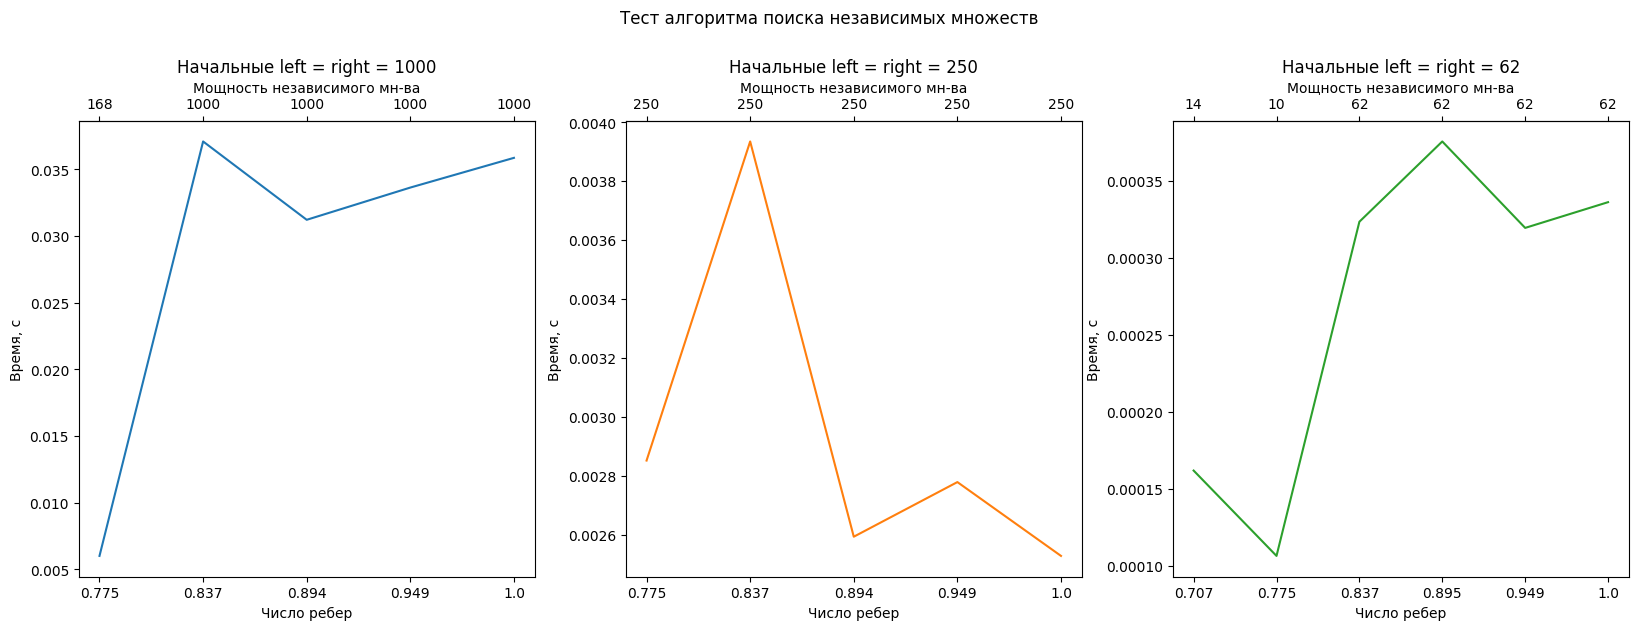

In [91]:
axes_n = 3
counter = 0
fig, axes = plt.subplots(1, axes_n, figsize=(
    20, 7), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1]})

fig.suptitle('Тест алгоритма поиска независимых множеств')

colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(axes_n):
    start = sets_data_n[i]
    axes[i].set_title("Начальные left = right = {}".format(start))
    axes[i].set(xlabel='Число ребер', ylabel='Время, с')

    edge_probability = [round(x / start, 3)
                        for x in np.sqrt(sets_data_vertices[i])]
    ticks = np.arange(len(sets_data_vertices[i]), 0, -1)

    secax = axes[i].secondary_xaxis('top')
    secax.set_xticks(ticks, sets_data_power[i])
    secax.set_xlabel('Мощность независимого мн-ва')

    axes[i].set_box_aspect(1)
    axes[i].plot(ticks,
                 sets_data_time[i], colors[i])
    axes[i].set_xticks(ticks, edge_probability)
plt.show()
